In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from Data_Processing import preprocessing, modify_target_binary
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, recall_score, accuracy_score, roc_curve, roc_auc_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
rf_model = load(r"models\random_forest_model.joblib")
xgb_model = load(r"models\xgb_model_1.joblib")
print("Models Loaded!")

Models Loaded!


C:\Users\andre\AppData\Local\Temp\ipykernel_3736\501181030.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_df = pd.read_csv("data/accepted_2007_to_2018Q4.csv")


DataFrame read!
Processing finished!
Mathews correlation coefficient between XGBoost model and Random Forest model: 0.8450
Random Forest model metrics: 


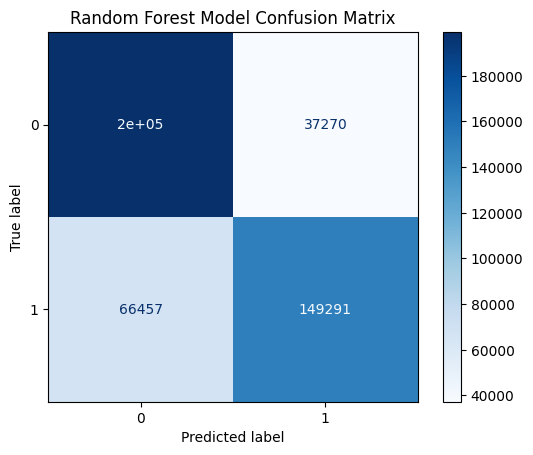

F1_score : 0.7422
Recall : 0.6920
Accuracy : 0.7706
XGBoost model metrics: 


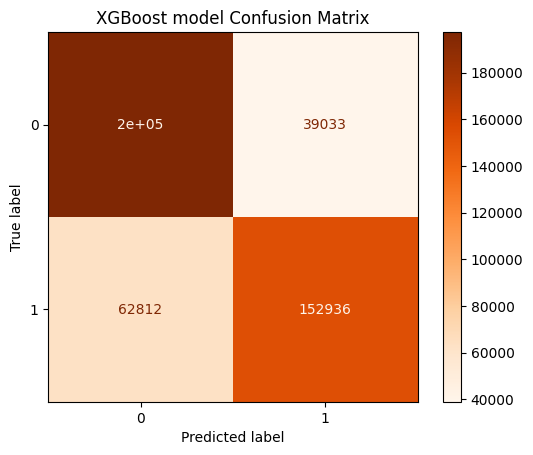

F1_score : 0.7502
Recall : 0.7089
Accuracy : 0.7747


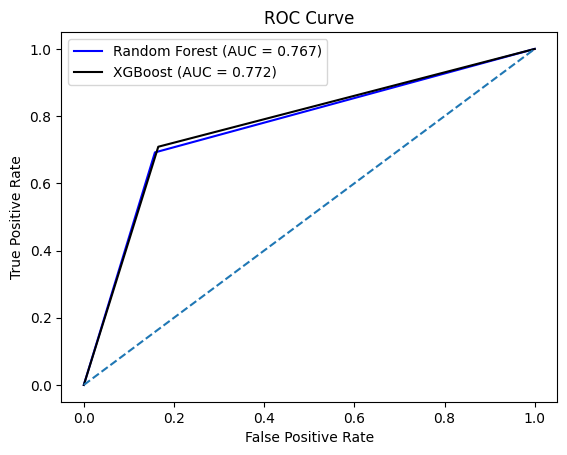

In [5]:
loan_df = pd.read_csv("data/accepted_2007_to_2018Q4.csv")
print("DataFrame read!")
loan_df = modify_target_binary(loan_df, "loan_status")
# Remove Current/Issued targets before preprocessing
loan_df = loan_df.loc[~loan_df["loan_status"].isin(["Current","Issued"])].copy()
X = loan_df.drop(columns=["loan_status"])
y = loan_df["loan_status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, 
                                                    random_state = 42, 
                                                    shuffle = True, 
                                                    stratify = y)

X_test = preprocessing(X_test)
print("Processing finished!")
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
mcc = matthews_corrcoef(xgb_preds,rf_preds)
print(f"Mathews correlation coefficient between XGBoost model and Random Forest model: {mcc:.4f}")
print("Random Forest model metrics: ")
rf_cm = confusion_matrix(y_test, rf_preds)
disp = ConfusionMatrixDisplay(rf_cm)
disp.plot(cmap = "Blues")
plt.title("Random Forest Model Confusion Matrix")
plt.show()
print(f"F1_score : {f1_score(y_test, rf_preds):.4f}")
print(f"Recall : {recall_score(y_test, rf_preds):.4f}")
print(f"Accuracy : {accuracy_score(y_test, rf_preds):.4f}")
print("XGBoost model metrics: ")
xgb_cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(xgb_cm)
disp.plot(cmap = "Oranges")
plt.title("XGBoost model Confusion Matrix")
plt.show()
print(f"F1_score : {f1_score(y_test, xgb_preds):.4f}")
print(f"Recall : {recall_score(y_test, xgb_preds):.4f}")
print(f"Accuracy : {accuracy_score(y_test, xgb_preds):.4f}")
# Plotting ROC curves
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_preds)
rf_auc = roc_auc_score(y_test, rf_preds)
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_preds)
xgb_auc = roc_auc_score(y_test, xgb_preds)
plt.figure()
plt.plot(rf_fpr, rf_tpr, color = 'blue', label=f"Random Forest (AUC = {rf_auc:.3f})")
plt.plot(xgb_fpr, xgb_tpr, color = 'black', label=f"XGBoost (AUC = {xgb_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_3736\796239650.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')


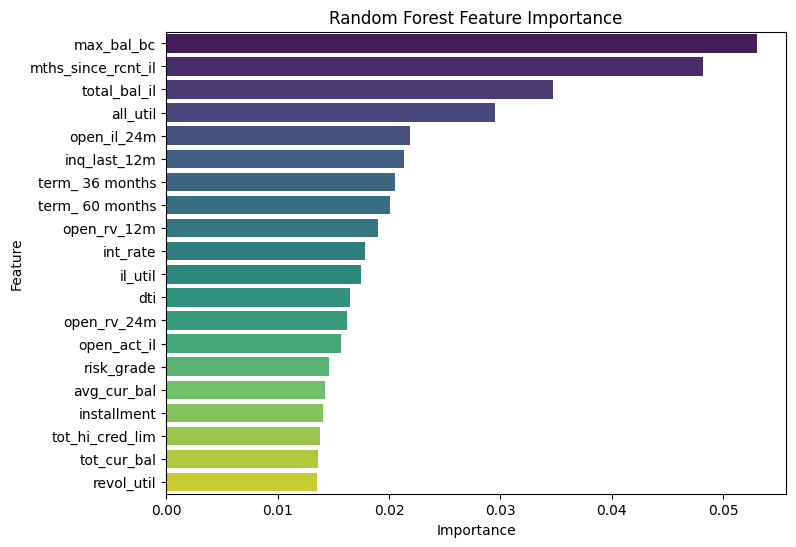

In [7]:
# Look at feature importance
feature_importances = rf_model.feature_importances_
feature_names = X_test.columns
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
feat_imp = feat_imp.sort_values(by = "Importance", ascending= False)[:20]
plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Results of experiment
- XGBoost outperformed Random Forest model in the test set with a slighter higher ROC area, but the two models predictions had a high mathew's correlation coeffiecient ~ 0.85
- According to the Random Forest model the three most important features for the prediction are maximum balance owed on all revolving accounts,
months since most recent installment accounts opened and total current balance of all installment accounts.
- Due to the nature of the dataset it was not clear at which datetime the features were provided at the issue date of the loan, but the data-leaking forward looking features such as total amount paid on the loan were removed to ensure fair treatment of the approval of the loan